In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import missingno as msn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 

pd.set_option("display.max_columns", 35)

In [50]:
# Loading the data
dataset= pd.read_csv('hotel_bookings.csv')
dataset.head() # print top 5 rows

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
# Shape of the dataset
dataset.shape

(119390, 32)

<AxesSubplot:>

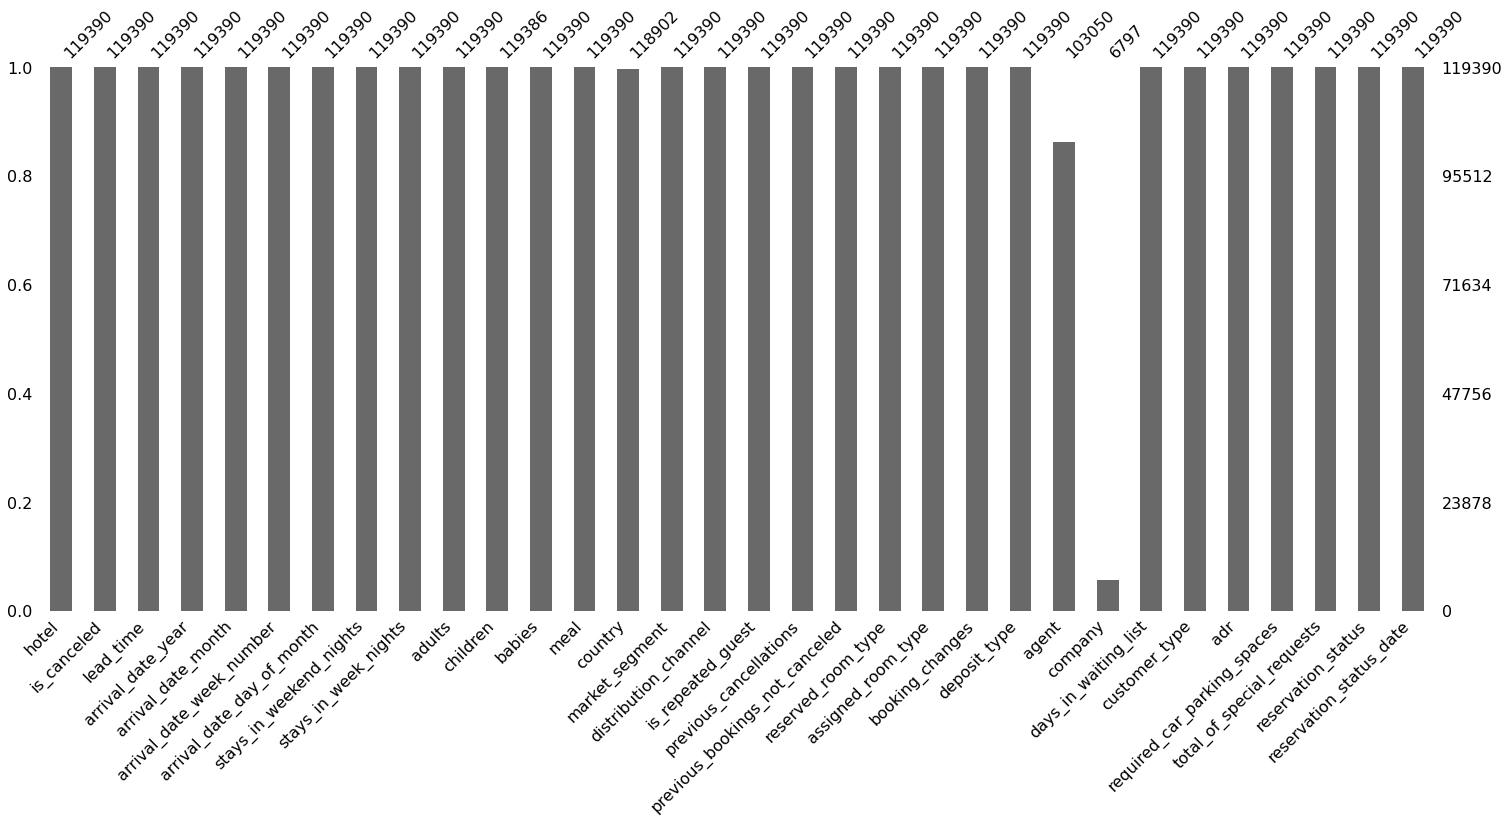

In [9]:
# Loooking for missing value
msn.bar(dataset)

In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [51]:
# Replacing missing values
nan_data= {'children': 0.0, 'country': 'unknown', 'agent': 0, 'company': 0}
cln_dataset= dataset.fillna(nan_data)
# Undefined in meal feature is equal to SC
cln_dataset["meal"].replace("Undefined", "SC", inplace=True)

<AxesSubplot:>

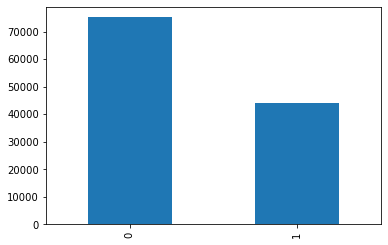

In [21]:
# Target feature's value distribution
plt.figure
dataset['is_canceled'].value_counts().plot(kind= 'bar')

In [45]:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features
X = cln_dataset.drop(["is_canceled"], axis=1)[features]
y = cln_dataset["is_canceled"]

num_transformer = SimpleImputer(strategy="constant")
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])


# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])


In [66]:
# define models to test:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(C=1, fit_intercept= True, random_state=123,n_jobs=None, penalty='l2', max_iter=1000)),
               ("XGB_model", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = StratifiedKFold(n_splits=kfolds, shuffle=True, random_state=42)

# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in base_models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")
    

DT_model cross validation accuarcy score: 0.8239 +/- 0.0014 (std) min: 0.8219, max: 0.8255
RF_model cross validation accuarcy score: 0.8657 +/- 0.0011 (std) min: 0.8643, max: 0.8674
LR_model cross validation accuarcy score: 0.8082 +/- 0.0014 (std) min: 0.8062, max: 0.8102
XGB_model cross validation accuarcy score: 0.8464 +/- 0.0013 (std) min: 0.8449, max: 0.8483


### Pycaret: Model Building

In [52]:
from pycaret.classification import *
#label=cln_dataset.pop('is_canceled')
bin_classifiers= setup(data= cln_dataset, target= 'is_canceled', session_id= 123)

,Description,Value
0,session_id,123
1,Target,is_canceled
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(119390, 32)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,20
8,Ordinal Features,False
9,High Cardinality Features,False


In [53]:
best_model= compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,36.7940
nb,Naive Bayes,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.5570
dt,Decision Tree Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.3640
ridge,Ridge Classifier,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4270
rf,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,5.4260
ada,Ada Boost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.2620
gbc,Gradient Boosting Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,17.3280
et,Extra Trees Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,7.0280
xgboost,Extreme Gradient Boosting,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,23.1960
lightgbm,Light Gradient Boosting Machine,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.9680


### 
    10 models have perfect socre for this data, let's see parameters of LogisticRegression

In [54]:
best_model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
lr= create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


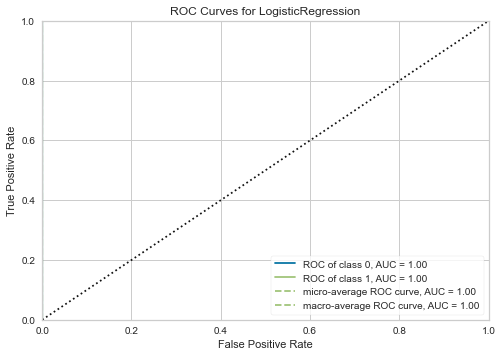

In [60]:
plot_model(lr, plot= 'auc')

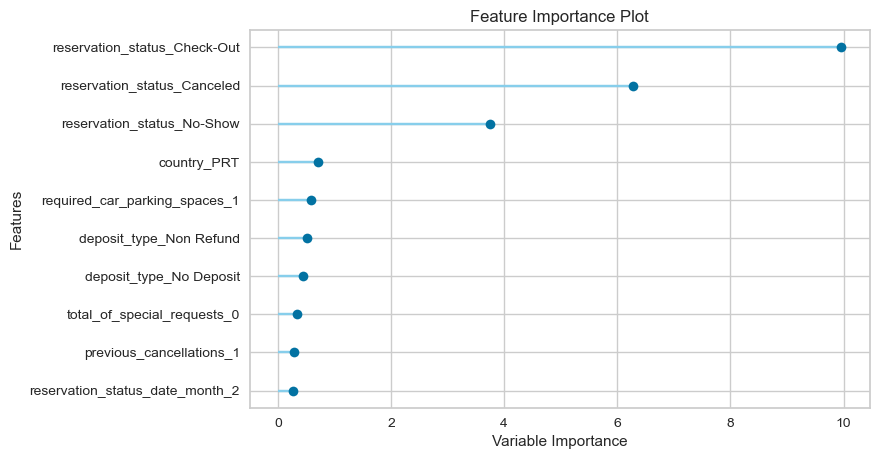

In [61]:
plot_model(lr, plot='feature')

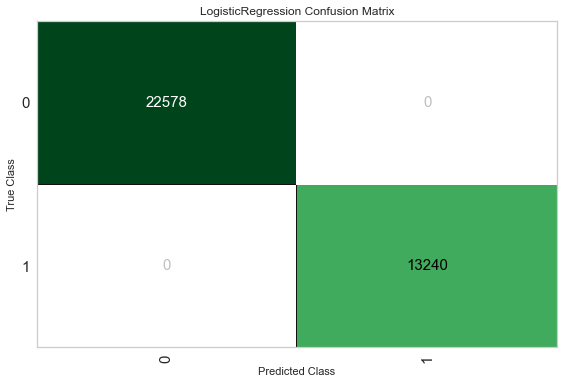

In [62]:
plot_model(lr, plot= 'confusion_matrix')